# Аналитика в Яндекс.Афише

## Описание проекта

### Данные:
- лог сервера с данными о посещениях сайта Яндекс.Афиши с июня 2017 по конец мая 2018 года,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

### Цели и задачи:
Необходимо выяснить, как клиенты пользуются сервисом, когда делают первые покупки на сайте, сколько денег приносит компании каждый клиент, когда расходы на привлечение клиента окупаются.

### 1. [Открытие данных](#start)
### 2. [Предобработка данных](#preprocessing)
### 3. [Продукт](#product)
- [3.1 Количество пользователей в день, неделю, месяц](#product_1)
- [3.2 Количество сессий в день](#product_2)
- [3.3 Длительность одной сессии](#product_3)
- [3.4 Количество возвращающихся пользователей](#product_4)

### 4. [Продажи](#sales)
- [4.1 Время до первой покупки](#sales_1)
- [4.2 Количество покупок за период](#sales_2)
- [4.3 Средний чек](#sales_3)
- [4.4 Сколько денег приносит каждый клиент (LTV)](#sales_4)
    - [4.4.1 LTV по когортам](#sales_4_1)
    - [4.4.2 LTV по устройствам](#sales_4_2)
    - [4.4.3 LTV по источникам](#sales_4_3)

### 5. [Маркетинг](#marketing)
- [5.1 Расходы на рекламу](#marketing_1)
- [5.2 Стоимость привлечения одного покупателя (САС)](#marketing_2)
- [5.3 Окупаемость расходов (ROI)](#marketing_3)

### 6. [Выводы](#conclusion)

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np

## <a id="start">1. Открытие данных</a>

In [8]:
visits = pd.read_csv('C:/Users/liana/datasets/visits_log.csv')
orders = pd.read_csv('C:/Users/liana/datasets/orders_log.csv')
costs = pd.read_csv('C:/Users/liana/datasets/costs.csv')

In [9]:
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Uid — уникальный идентификатор пользователя

Device — категория устройства пользователя

Start Ts — дата и время начала сессии

End Ts — дата и время окончания сессии

Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [10]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Uid — уникальный id пользователя, который сделал заказ

Buy Ts — дата и время заказа

Revenue — выручка Яндекс.Афиши с этого заказа

In [11]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


source_id — идентификатор рекламного источника

dt — дата

costs — затраты на этот рекламный источник в этот день

In [12]:
print('Количество дублированных строк в данных о посещениях:', visits[visits.duplicated()].shape[0])
print('Количество дублированных строк в данных о заказах:', orders[orders.duplicated()].shape[0])
print('Количество дублированных строк в данных о расходах:', costs[costs.duplicated()].shape[0])

Количество дублированных строк в данных о посещениях: 0
Количество дублированных строк в данных о заказах: 0
Количество дублированных строк в данных о расходах: 0


### Минивывод:

1. Пропусков и повторов в данных нет.
2. В данных о посещениях и заказах необходимо привести заголовки к удобному виду(snake_case).
3. Все даты из типа object привести  к datetime.

## <a id="preprocessing">2. Предобработка данных</a>

In [13]:
#замена названий заголовков 

visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

In [14]:
#замена типа данных в датах

visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

## <a id="product">3. Отчеты о продукте</a>

### <a id="product_1">3.1 Количество пользователей в день, неделю, месяц</a>

In [15]:
#добавляем столбцы с годом, месяцем, неделей и датой для дальнейших вычислений
#считаем длительность каждой сессии

visits['year'] = visits['start_ts'].dt.year
visits['month'] = visits['start_ts'].dt.month
visits['week'] = visits['start_ts'].dt.week
visits['day'] = visits['start_ts'].dt.date
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()
visits

,device,end_ts,source_id,start_ts,uid,year,month,week,day,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,7,30,2017-07-29,19.0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25,19.0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03,19.0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02,19.0


In [16]:
#создаем список для расчета dau, wau, mau

list_of_time = ['day', 'week', 'month']
metrics_total = pd.DataFrame(columns = list_of_time)
metrics_by_device = pd.DataFrame(columns = list_of_time)
metrics_by_source = pd.DataFrame(columns = list_of_time)

In [17]:
#количество уникальных пользователей в день, неделю, месяц за все время

for i in list_of_time:
    metrics_total[i] = visits.groupby(i).agg({'uid':'nunique'}).mean()
metrics_total.columns = ['dau', 'wau', 'mau']
metrics_total

,dau,wau,mau
uid,907.991758,5825.288462,23228.416667


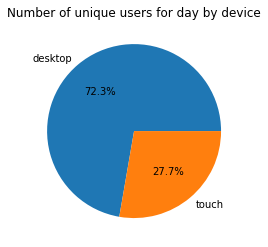

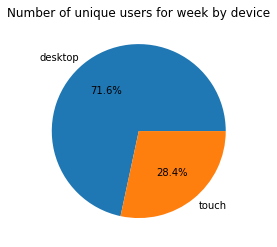

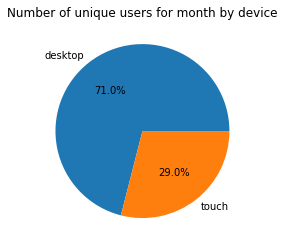

,dau,wau,mau
device,,,
desktop,659.244505,4208.173077,16724.916667
touch,252.873278,1666.230769,6825.916667


In [18]:
#считаем dau, wau, mau с разбивкой по устройствам за все время

for i in list_of_time:
    pivot_devices = visits.pivot_table(
        index = i,
        columns = 'device',
        values = 'uid',
        aggfunc = ['count', 'nunique']
    )
    #print('Number of unique users for {} by'.format(i), pivot_devices['nunique'].mean())
    metrics_by_device[i] = pivot_devices['nunique'].mean()
    plt.pie(pivot_devices['nunique'].mean(), autopct = '%1.1f%%', labels = ['desktop', 'touch'])
    plt.title('Number of unique users for {} by device'.format(i))
    plt.show()
metrics_by_device.columns = ['dau', 'wau', 'mau']
metrics_by_device

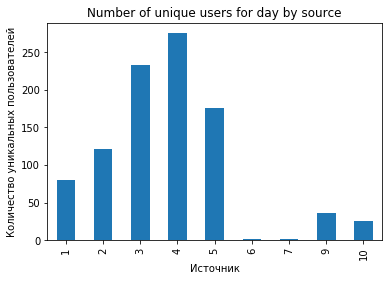

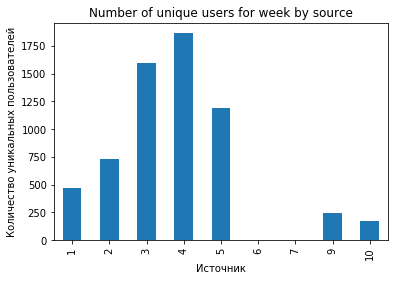

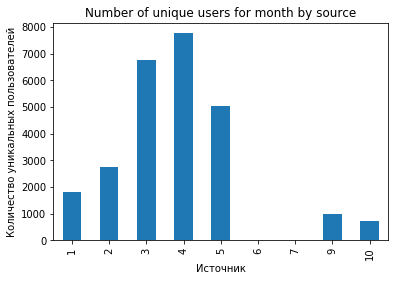

,dau,wau,mau
source_id,,,
1,80.557692,472.173077,1818.750000
2,120.707989,729.192308,2752.083333
3,232.865014,1596.000000,6758.833333
4,275.454545,1864.365385,7765.666667
5,175.622590,1189.903846,5017.916667
6,1.000000,1.000000,1.000000
7,1.058824,1.333333,2.833333
9,36.110193,243.288462,987.000000
10,26.033058,169.750000,707.000000


In [19]:
#считаем dau, wau, mau с разбивкой по источникам

for i in list_of_time:
    pivot_sources = visits.pivot_table(
        index = i,
        columns = 'source_id',
        values = 'uid',
        aggfunc = ['count', 'nunique']
    )
    #print('Number of unique users for {} by'.format(i), pivot_sources['nunique'].mean())
    metrics_by_source[i] = pivot_sources['nunique'].mean()
    pivot_sources['nunique'].mean().plot(kind = 'bar', title = 'Number of unique users for {} by source'.format(i))
    plt.ylabel('Количество уникальных пользователей')
    plt.xlabel('Источник')
    plt.show()
metrics_by_source.columns = ['dau', 'wau', 'mau']
metrics_by_source

In [20]:
#считаем изменение dau, mau, wau по времени

list_list = [
    'day',
    ['year', 'month'],
    ['year', 'week']
]

list_t = ['device', 'source_id']

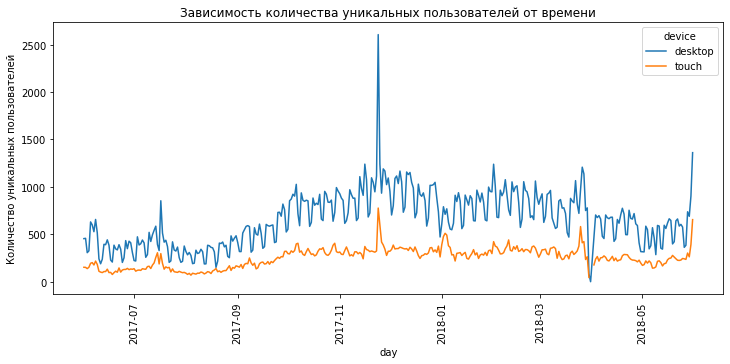

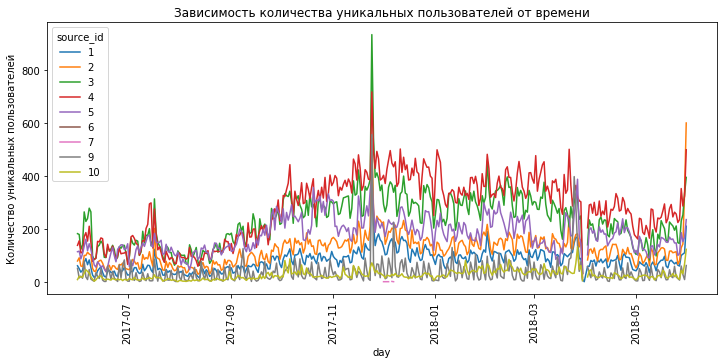

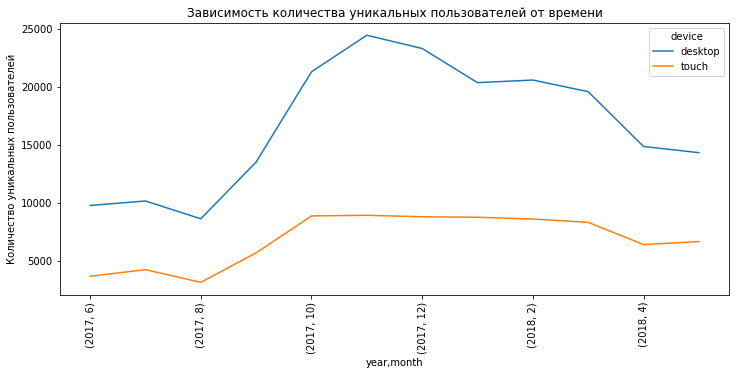

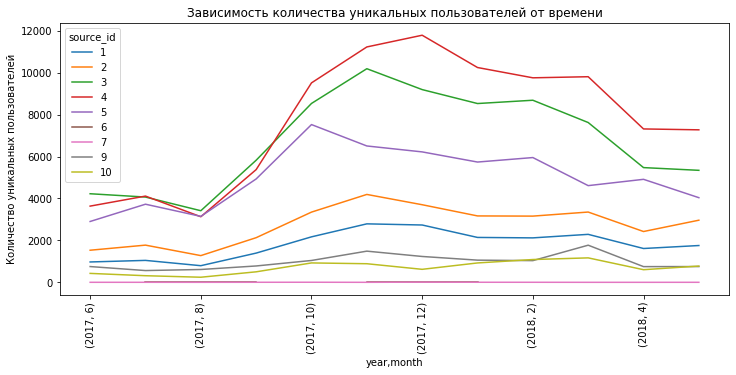

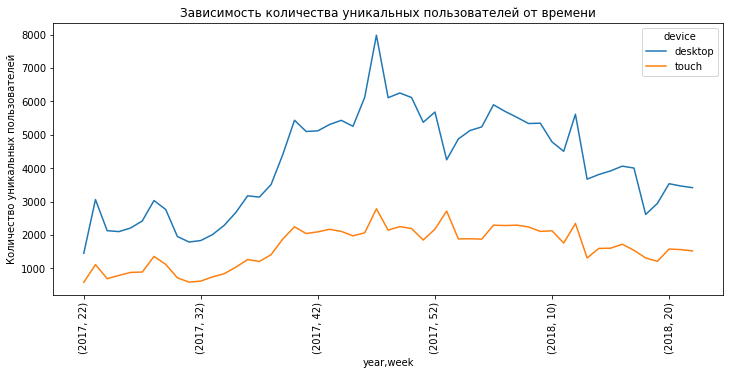

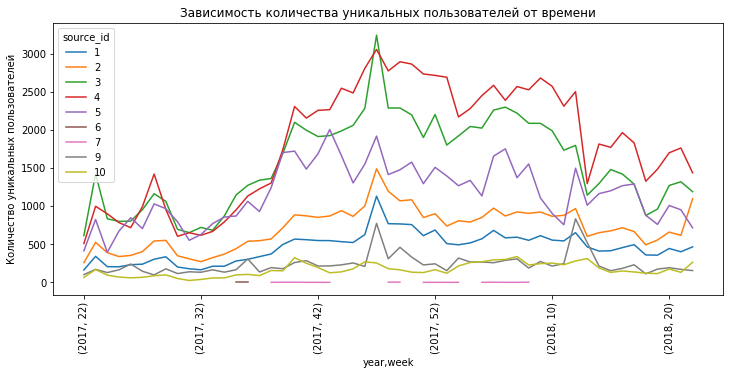

In [21]:
#строим графики изменения dau, mau, wau по времени

for i in list_list:
    for j in list_t:       
        visits_pivot = visits.pivot_table(
            index = i,
            columns = j,
            values = 'uid',
            aggfunc = 'nunique')
        visits_pivot.plot(title = 'Зависимость количества уникальных пользователей от времени', figsize = (12, 5))
        plt.ylabel('Количество уникальных пользователей')
        plt.xticks(rotation = 90)

### Минивывод:

1. Расчет dau, wau, mau по данным за все время показал, что пользователи, пользующиеся сервисом с компьютеров, составляют примерно 70% от всех пользователей. Следовательно, на пользователей с телефонами приходится 30%. 
2. Больше всего пользователей из источников под номерами: 4, 3, 5.
3. В ноябре был резкий скачок количества уникальных пользователей с компьютеров и пользователей из источников 3 и 4.

### <a id="product_2">3.2 Количество сессий в день</a>

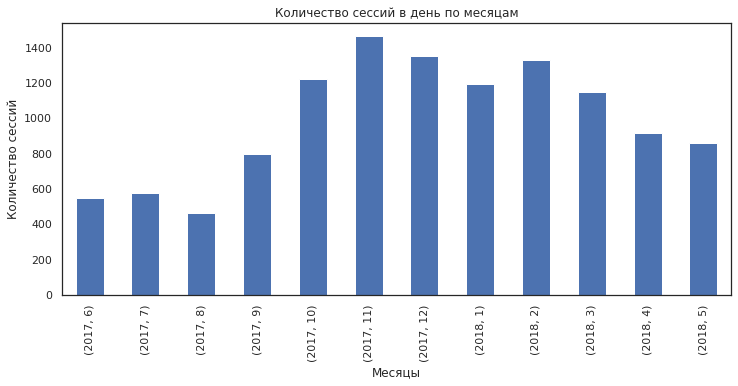

year  month
2017  6         550.166667
      7         575.096774
      8         463.064516
      9         796.900000
      10       1222.677419
      11       1465.633333
      12       1354.290323
2018  1        1191.580645
      2        1327.928571
      3        1150.935484
      4         914.310345
      5         859.193548
Name: uid, dtype: float64

In [21]:
#количество сессий в день по месяцам

sessions_day = visits.groupby(['year', 'month', 'day']).agg({'uid':'count'})
sessions_day_mean = sessions_day.groupby(['year', 'month'])['uid'].mean()
sessions_day_mean.plot(kind = 'bar', title = 'Количество сессий в день по месяцам', figsize = (12, 5))
plt.ylabel('Количество сессий')
plt.xlabel('Месяцы')
plt.show()
sessions_day_mean

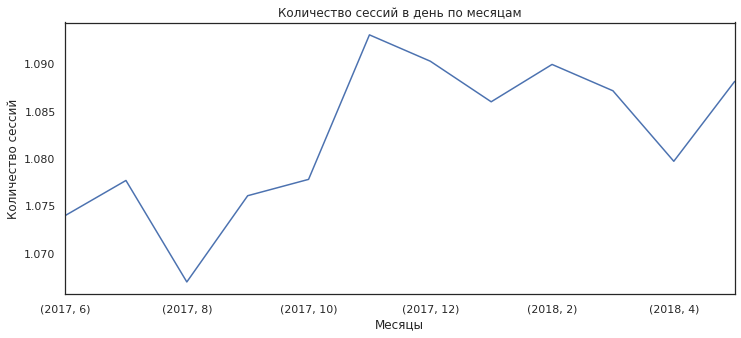

year  month
2017  6        1.073938
      7        1.077657
      8        1.066927
      9        1.076044
      10       1.077773
      11       1.093053
      12       1.090265
2018  1        1.085976
      2        1.089924
      3        1.087141
      4        1.079686
      5        1.088130
Name: sessions_per_user, dtype: float64

In [22]:
#количество сессий в день на одного пользователя по месяцам

sessions_days = visits.groupby(['year', 'month', 'day']).agg({'uid':['count', 'nunique']})
sessions_days['sessions_per_user'] = sessions_days['uid']['count'] / sessions_days['uid']['nunique']
sessions_days.groupby(['year', 'month'])['sessions_per_user'].mean().plot(title = 'Количество сессий в день по месяцам', figsize = (12, 5))
plt.ylabel('Количество сессий')
plt.xlabel('Месяцы')
plt.show()
sessions_days.groupby(['year', 'month'])['sessions_per_user'].mean()

In [23]:
print('Среднее количество сессий в день на одного пользователя: {:.2f}'.format(sessions_days.groupby(['year', 'month'])['sessions_per_user'].mean().mean()))

Среднее количество сессий в день на одного пользователя: 1.08


In [24]:
print('Среднее количество сессий в день: {:.2f}'.format(sessions_day_mean.mean()))

Среднее количество сессий в день: 989.31


### Минивывод:

1. Количество сессий начало расти в сентябре, и стало снижаться только в марте, что говорит о зависимости от сезона. В холодное время года люди больше заинтересованы в досуге внутри помещений.
2. Количество сессий в день на пользователя достигло максимального значения в ноябре, как и среднее количество сессий в день. Возможно в это время люди планировали, как провести новогодние выходные.

### <a id="product_3">3.3 Длительность одной сессии</a>

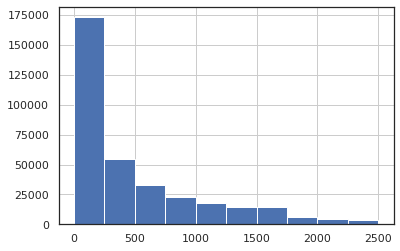

In [25]:
#строим гистограмму длительности сессий

visits['duration'].hist(range = (0, 2500))

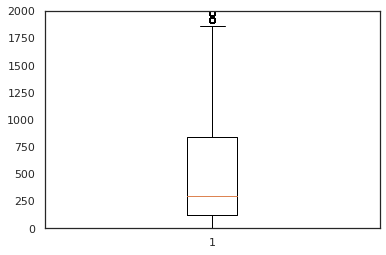

In [26]:
plt.boxplot(visits['duration'])
plt.ylim(0, 2000)
plt.show()

In [27]:
visits['duration'].describe()

count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: duration, dtype: float64

In [28]:
#убираем отрицательные значения в длительности сессий
#возможно, перепутались столбцы начала и конца сессий, поэтому умножаем на -1

visits.loc[visits['duration'] < 0, 'duration'] = visits['duration']*(-1)

In [29]:
visits['duration'].describe()

count    359400.000000
mean        643.051731
std         997.110965
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: duration, dtype: float64

In [30]:
visits['duration'].mode()

0    60.0
dtype: float64

### Минивывод:

1. Средняя длительность сессии составляет 643 с (10 минут 43 с), медианная - 300с (5 минут), а мода - 60 с.

### <a id="product_4">3.4 Доля возвращающихся пользователей</a>

In [31]:
#находим время первого посещения

first_visits = visits.groupby('uid')['start_ts'].min()
first_visits = first_visits.rename('first_visits')

In [32]:
#добавляем столбец с первым посещением

new_visits = visits.merge(first_visits, on = 'uid')
new_visits

,device,end_ts,source_id,start_ts,uid,year,month,week,day,duration,first_visits
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680.0,2018-03-09 20:05:00
...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018,4,17,2018-04-23,480.0,2018-04-23 21:11:00
359396,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017,11,45,2017-11-08,0.0,2017-11-08 13:39:00
359397,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017,7,31,2017-07-31,1080.0,2017-07-31 12:13:00
359398,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018,3,12,2018-03-20,840.0,2018-03-20 15:11:00


In [33]:
#столбец для группировки по месяцам
#заменяем дни в месяцах на 1, месяц и год остаются

new_visits['first_day'] = pd.to_datetime(new_visits['first_visits'].dt.date.apply(lambda dt: dt.replace(day=1)))

In [34]:
#добавляем столбец с "возрастом" сессии относительного первого посещения

new_visits['lifetime'] = ((new_visits['start_ts'] - new_visits['first_visits']) / np.timedelta64(1,'M')).round().astype(int)
new_visits

,device,end_ts,source_id,start_ts,uid,year,month,week,day,duration,first_visits,first_day,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680.0,2018-03-09 20:05:00,2018-03-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018,4,17,2018-04-23,480.0,2018-04-23 21:11:00,2018-04-01,0
359396,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017,11,45,2017-11-08,0.0,2017-11-08 13:39:00,2017-11-01,0
359397,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017,7,31,2017-07-31,1080.0,2017-07-31 12:13:00,2017-07-01,0
359398,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018,3,12,2018-03-20,840.0,2018-03-20 15:11:00,2018-03-01,0


In [35]:
#объединяем в когорты по месяцу первого посещения

cohorts = new_visits.groupby(['first_day', 'lifetime']).agg({'uid':'nunique'}).reset_index()

In [36]:
#находим размер когорт

new_cohorts = cohorts[cohorts['lifetime'] == 0][['first_day', 'uid']]
new_cohorts = new_cohorts.rename(columns={'uid':'cohort_users'})

In [37]:
#добавляем столбец с размером когорт в объединенный датафрейм

cohorts = cohorts.merge(new_cohorts, on = 'first_day')
cohorts

,first_day,lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,986,13259
2,2017-06-01,2,710,13259
3,2017-06-01,3,813,13259
4,2017-06-01,4,921,13259
...,...,...,...,...
85,2018-04-01,0,15709,15709
86,2018-04-01,1,629,15709
87,2018-04-01,2,67,15709
88,2018-05-01,0,15273,15273


In [38]:
#считаем retention rate
#без умножения на 100, проценты будут отображаться на тепловой карте

cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] 

In [39]:
#создаем сводную таблицу

cohorts_pivot = cohorts.pivot_table(
    index = 'first_day',
    columns = 'lifetime',
    values = 'retention'
)
cohorts_pivot.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
first_day,,,,,,,,,,,,,
2017-06-01,1.0,0.074365,0.0535485,0.0613168,0.0694623,0.06637,0.0638811,0.0558111,0.0560374,0.0498529,0.0414813,0.0396712,0.013274
2017-07-01,1.0,0.056849,0.0517504,0.053653,0.0565449,0.0487062,0.0449772,0.0490868,0.0372146,0.0291476,0.0244292,0.00540335,
2017-08-01,1.0,0.069247,0.0617818,0.0591298,0.051272,0.0418426,0.041548,0.0338867,0.029172,0.022984,0.00324133,,
2017-09-01,1.0,0.076509,0.0664511,0.0494492,0.0400503,0.0396911,0.0331657,0.0256825,0.0199952,0.00257423,,,
2017-10-01,1.0,0.073565,0.0526235,0.0383416,0.0365323,0.0311044,0.0211341,0.017862,0.00327213,,,,
2017-11-01,1.0,0.069510,0.0462419,0.0388285,0.0315986,0.0240385,0.0185702,0.0026424,,,,,
2017-12-01,1.0,0.051448,0.0409213,0.0290882,0.0216084,0.0161865,0.0027703,,,,,,
2018-01-01,1.0,0.053881,0.0358911,0.0258133,0.0171941,0.00185644,,,,,,,
2018-02-01,1.0,0.048205,0.0265802,0.0181556,0.0020273,,,,,,,,


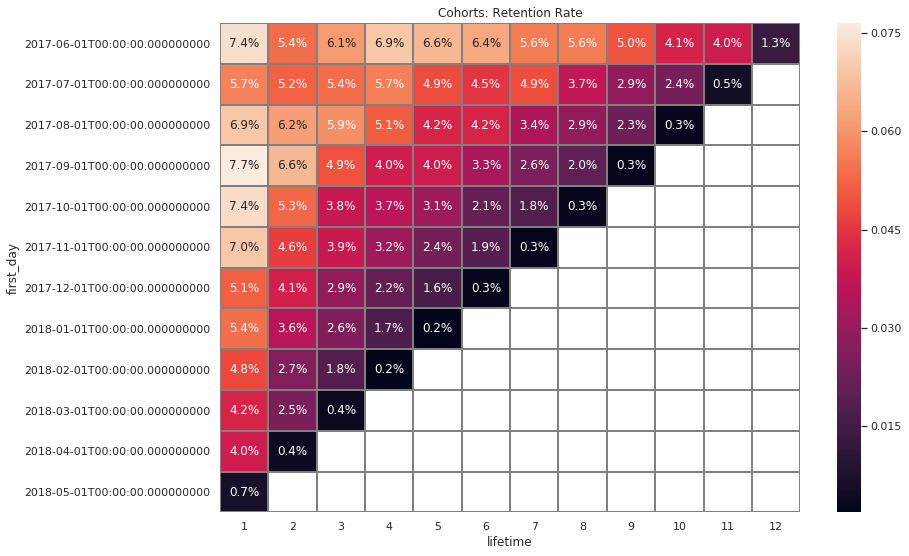

In [40]:
#строим тепловую карту
#убираем столбец с lifetime = 0 для наглядности

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Retention Rate')
sns.heatmap(cohorts_pivot.iloc[:, 1:13], annot=True, fmt='.1%', linewidths=1, linecolor='gray')

In [38]:
#считаем churn rate

cohorts['churn'] = cohorts.groupby('first_day')['uid'].pct_change() 

In [39]:
churn_pivot = cohorts.pivot_table(
    index='first_day',
    columns='lifetime',
    values='churn',
    aggfunc='sum')
churn_pivot.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
first_day,,,,,,,,,,,,,
2017-06-01,0.0,-0.925635,-0.279919,0.14507,0.132841,-0.0445168,-0.0375,-0.126328,0.00405405,-0.110363,-0.167927,-0.0436364,-0.665399
2017-07-01,0.0,-0.943151,-0.0896921,0.0367647,0.0539007,-0.138627,-0.0765625,0.0913706,-0.24186,-0.216769,-0.16188,-0.778816,
2017-08-01,0.0,-0.930753,-0.107801,-0.0429253,-0.13289,-0.183908,-0.00704225,-0.184397,-0.13913,-0.212121,-0.858974,,
2017-09-01,0.0,-0.923491,-0.131455,-0.255856,-0.190073,-0.00896861,-0.164404,-0.225632,-0.221445,-0.871257,,,
2017-10-01,0.0,-0.926435,-0.284668,-0.271397,-0.0471888,-0.148577,-0.320545,-0.154827,-0.81681,,,,
2017-11-01,0.0,-0.930490,-0.334741,-0.160317,-0.1862,-0.239257,-0.227481,-0.857708,,,,,
2017-12-01,0.0,-0.948552,-0.204615,-0.289168,-0.257143,-0.250916,-0.828851,,,,,,
2018-01-01,0.0,-0.946119,-0.33388,-0.280788,-0.333904,-0.892031,,,,,,,
2018-02-01,0.0,-0.951795,-0.448598,-0.316949,-0.888337,,,,,,,,


In [1]:
#строим тепловую карту

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Churn Rate')
sns.heatmap(churn_pivot.iloc[:, 1:13], annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

NameError: name 'sns' is not defined

### Минивывод:

1. Коэффициент удержания (retention rate) выше всего в первой когорте, с каждой следующей начинает падать.
2. Коэффициент оттока (churn rate) имеет положительные значения только в первых двух когортах.

### <a id="sales_1">4.1 Время до первой покупки</a>

In [41]:
#находим время первой покупки

first_buy = orders.groupby('uid').agg({'buy_ts':'min'})
first_buy.columns = ['first_buy_ts']

In [42]:
#добавляем время первой покупки к датафрейму с покупками

new_orders = orders.merge(first_buy, on = 'uid')
new_orders

,buy_ts,revenue,uid,first_buy_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00


In [43]:
#находим значения source_id и device для первого посещения
#добавляем к датафрейму с покупками

abc = new_visits[new_visits['start_ts'] == new_visits['first_visits']][['uid', 'device', 'source_id', 'first_visits']]
new_orders = new_orders.merge(abc, on = ['uid', 'uid'], how = 'inner')
new_orders

,buy_ts,revenue,uid,first_buy_ts,device,source_id,first_visits
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,desktop,1,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,desktop,2,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,desktop,2,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,desktop,2,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,desktop,3,2017-06-01 07:31:00
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,touch,4,2018-05-31 09:11:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,desktop,10,2018-05-31 23:05:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,desktop,3,2018-05-31 23:52:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,desktop,3,2017-10-23 12:32:00


In [44]:
#находим время от первого посещения до первой покупки

new_orders['time_to_buy'] = new_orders['first_buy_ts'] - new_orders['first_visits']

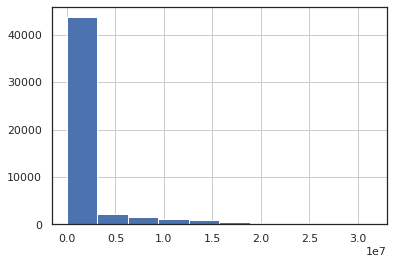

In [45]:
#строим гистограмму

new_orders['time_to_buy'].dt.total_seconds().hist()

In [46]:
new_orders['time_to_buy'].describe()

count                      50415
mean     17 days 14:48:59.437072
std      46 days 11:10:48.112360
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:22:00
75%              4 days 07:51:00
max            363 days 07:04:00
Name: time_to_buy, dtype: object

In [47]:
new_orders['time_to_buy'].dt.total_seconds().mode()

0    0.0
dtype: float64

### Минивывод:

Среднее время от первого посещения до покупки составляет 17+ дней, медианное - 22 минуты, а мода - 0.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Ну то есть мы можем сделать вывод, что в основном пользователи покупают в день посещения сайта. 
    
</div>

### <a id="sales_2">4.2 Количество покупок за период</a>

In [48]:
#добавляем столбец с месяцем покупки 

new_orders['buy_date'] = pd.to_datetime(new_orders['buy_ts'].dt.date.apply(lambda dt: dt.replace(day=1)))
new_orders

,buy_ts,revenue,uid,first_buy_ts,device,source_id,first_visits,time_to_buy,buy_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,desktop,1,2017-06-01 00:09:00,0 days 00:01:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,desktop,2,2017-06-01 00:14:00,0 days 00:11:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,desktop,2,2017-06-01 00:25:00,0 days 00:02:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,desktop,2,2017-06-01 00:14:00,0 days 00:15:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,desktop,3,2017-06-01 07:31:00,0 days 00:27:00,2017-06-01
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,touch,4,2018-05-31 09:11:00,0 days 14:39:00,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,desktop,10,2018-05-31 23:05:00,0 days 00:45:00,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,desktop,3,2018-05-31 23:52:00,0 days 00:02:00,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,desktop,3,2017-10-23 12:32:00,220 days 11:24:00,2018-05-01


In [49]:
#считаем количество покупок и количество пользователей, совершивших покупки

q_orders = new_orders.groupby('buy_date').agg({'uid':['count', 'nunique']})
q_orders

uid        
           count nunique
buy_date                
2017-06-01  2354    2023
2017-07-01  2363    1984
2017-08-01  1807    1472
2017-09-01  3387    2750
2017-10-01  5679    4675
2017-11-01  5659    4547
2017-12-01  6218    4942
2018-01-01  4721    3898
2018-02-01  5281    4258
2018-03-01  5326    4181
2018-04-01  3273    2744
2018-05-01  4346    3544
2018-06-01     1       1

In [50]:
#считаем количество покупок на каждого человека
#убираем месяц с одной покупкой

q_orders['buys_per_user'] = q_orders['uid']['count'] / q_orders['uid']['nunique']
q_orders = q_orders[0:12]

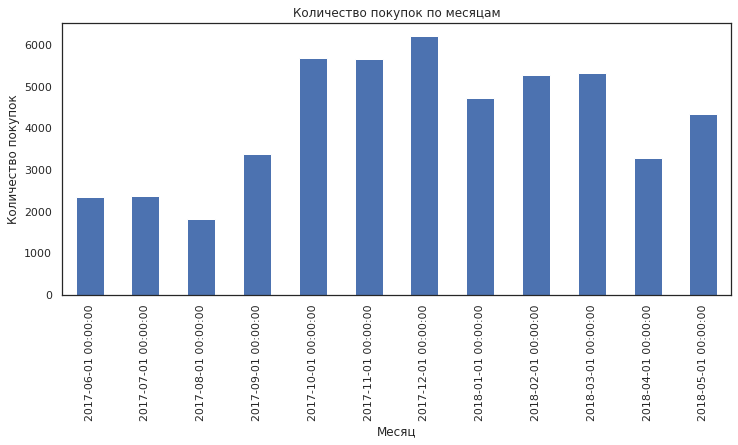

In [51]:
#общее количество покупок по месяцам

q_orders['uid']['count'].plot(kind = 'bar', title = 'Количество покупок по месяцам', figsize = (12, 5))
plt.xlabel('Месяц')
plt.ylabel('Количество покупок')
plt.show()

In [52]:
q_orders['buys_per_user']

buy_date
2017-06-01    1.163618
2017-07-01    1.191028
2017-08-01    1.227582
2017-09-01    1.231636
2017-10-01    1.214759
2017-11-01    1.244557
2017-12-01    1.258195
2018-01-01    1.211134
2018-02-01    1.240254
2018-03-01    1.273858
2018-04-01    1.192784
2018-05-01    1.226298
Name: buys_per_user, dtype: float64

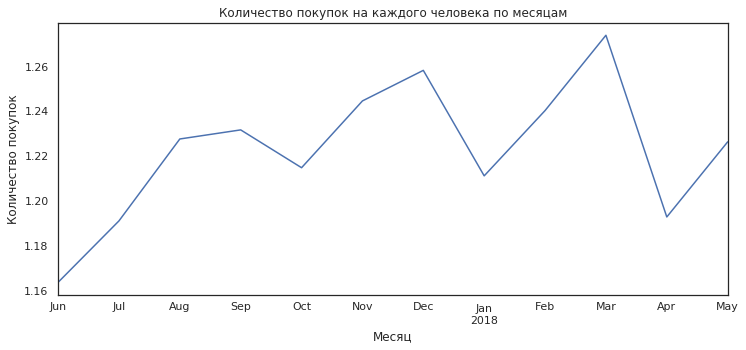

In [53]:
#количество покупок на каждого пользователя, совершившего покупки

q_orders['buys_per_user'].plot(title = 'Количество покупок на каждого человека по месяцам', figsize = (12, 5))
plt.xlabel('Месяц')
plt.ylabel('Количество покупок')
plt.show()

In [54]:
print('Среднее количество покупок в месяц: {:.2f}'.format(q_orders['uid']['count'].mean()))
print('Среднее количество покупок на человека: {:.2f}'.format(q_orders['buys_per_user'].mean()))

Среднее количество покупок в месяц: 4201.17
Среднее количество покупок на человека: 1.22


### Минивывод:

1. Количество покупок растет с сентября по декабрь, затем небольшое падение в январе, и в феврале-марте остается еще довольно высоким. 
2. Количество покупок на каждого человека достигает максимума в марте.

### <a id="sales_3">4.3 Средний чек</a>

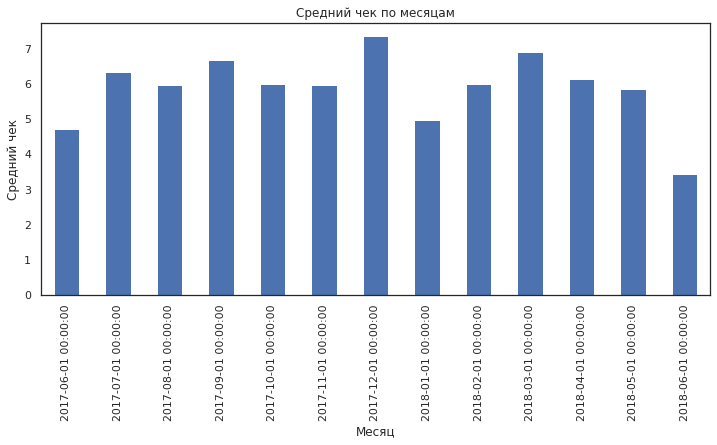

,sum,count,rev
buy_date,,,
2017-06-01,9557.49,2023,4.724414
2017-07-01,12539.47,1984,6.320297
2017-08-01,8758.78,1472,5.950258
2017-09-01,18345.51,2750,6.671095
2017-10-01,27987.70,4675,5.986674
2017-11-01,27069.93,4547,5.953360
2017-12-01,36388.60,4942,7.363132
2018-01-01,19417.13,3898,4.981306
2018-02-01,25560.54,4258,6.002945


In [55]:
#средний чек по всем данным по месяцам

total_rev = new_orders.groupby(['buy_date', 'uid']).agg({'revenue':'sum'})
total_rev = total_rev.groupby('buy_date').agg({'revenue':['sum', 'count']})
total_rev.columns = ['sum', 'count']
total_rev['rev'] = total_rev['sum'] / total_rev['count']
total_rev['rev'].plot(kind = 'bar', title = 'Средний чек по месяцам', figsize = (12, 5))
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.show()
total_rev

In [56]:
#средний чек по всем данным по месяцам для разных устройств

mean_rev = new_orders.groupby(['buy_date', 'device', 'uid']).agg({'revenue':'sum'})
mean_rev = mean_rev.groupby(['buy_date', 'device']).agg({'revenue':['sum', 'count']})
mean_rev.columns = ['sum', 'count']
mean_rev['rev'] = mean_rev['sum'] / mean_rev['count']
mean_rev.reset_index()

,buy_date,device,sum,count,rev
0,2017-06-01,desktop,8321.37,1702,4.889172
1,2017-06-01,touch,1236.12,321,3.850841
2,2017-07-01,desktop,10251.79,1577,6.500818
3,2017-07-01,touch,2287.68,407,5.620835
4,2017-08-01,desktop,7258.59,1200,6.048825
5,2017-08-01,touch,1500.19,272,5.515404
6,2017-09-01,desktop,15631.37,2208,7.079425
7,2017-09-01,touch,2714.14,542,5.007638
8,2017-10-01,desktop,23094.75,3815,6.053670
9,2017-10-01,touch,4892.95,860,5.689477


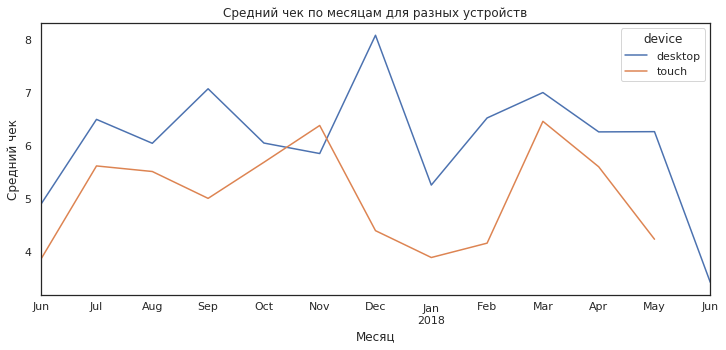

In [57]:
#строим график изменения среднего чека по месяцам для разных устройств

mean_rev.pivot_table(
    index = 'buy_date',
    columns = 'device',
    values = 'rev',
    aggfunc = 'mean'
).plot(title = 'Средний чек по месяцам для разных устройств', figsize = (12, 5))
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.show()

In [58]:
#средний чек по всем данным по месяцам для разных источников

mean_rev_s = new_orders.groupby(['buy_date', 'source_id', 'uid']).agg({'revenue':'sum'})
mean_rev_s = mean_rev_s.groupby(['buy_date', 'source_id']).agg({'revenue':['sum', 'count']})
mean_rev_s.columns = ['sum', 'count']
mean_rev_s['rev'] = mean_rev_s['sum'] / mean_rev_s['count']
mean_rev_s.reset_index()
mean_rev_s

sum  count       rev
buy_date   source_id                          
2017-06-01 1          1378.70    190  7.256316
           2          1043.68    235  4.441191
           3          2804.34    638  4.395517
           4          1959.84    413  4.745375
           5          1898.89    384  4.945026
...                       ...    ...       ...
2018-05-01 4          4656.30    947  4.916895
           5          2550.39    571  4.466532
           9           376.66     82  4.593415
           10          505.46    143  3.534685
2018-06-01 4             3.42      1  3.420000

[86 rows x 3 columns]

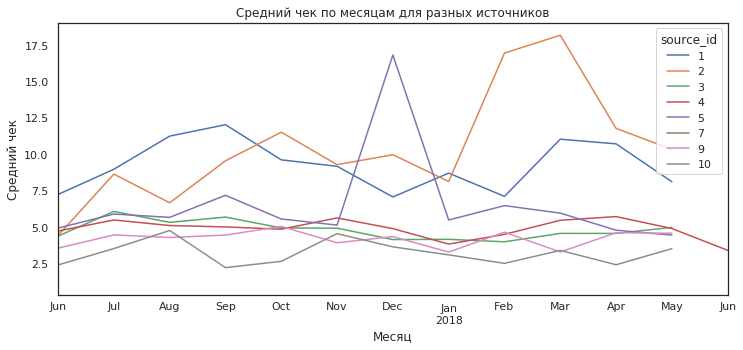

In [59]:
#строим график изменения среднего чека по месяцам для разных источников

mean_rev_s.pivot_table(
    index = 'buy_date',
    columns = 'source_id',
    values = 'rev',
    aggfunc = 'mean'
).plot(title = 'Средний чек по месяцам для разных источников', figsize = (12, 5))
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.show()

### Минивывод:

1. Максимальный средний чек в декабре.
2. Резкий скачок среднего чека в декабре у пользователей из 5 источника.
3. У пользователей из 2 источника максимальный средний чек в феврале-марте. Возможно, проводились какие-то акции в честь 23 февраля и 8 марта.
4. У пользователей с компьютеров максимальный средний чек в декабре, а у пользователей с телефонами в ноябре. Возможно, среди пользователей с телефонами больше молодежи, что объясняет меньший средний чек и пик в ноябре (обычно, билеты раньше стоят дешевле).
5. Средний чек больше у источников 1, 2, 5.

In [60]:
print('Средний чек: {:.1f}'.format(new_orders.groupby(['uid']).agg({'revenue':'sum'}).mean()[0]))

Средний чек: 6.9


### <a id="sales_4">4.4 Сколько денег приносит каждый клиент (LTV)</a>

#### <a id="sales_4_1">4.4.1 LTV по когортам</a>

In [61]:
#определяем время жизни в зависимости от первой покупки

new_orders['lifetime'] = ((new_orders['buy_ts'] - new_orders['first_buy_ts']) / np.timedelta64(1,'M')).round().astype(int)
new_orders

,buy_ts,revenue,uid,first_buy_ts,device,source_id,first_visits,time_to_buy,buy_date,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,desktop,1,2017-06-01 00:09:00,0 days 00:01:00,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,desktop,2,2017-06-01 00:14:00,0 days 00:11:00,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,desktop,2,2017-06-01 00:25:00,0 days 00:02:00,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,desktop,2,2017-06-01 00:14:00,0 days 00:15:00,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,desktop,3,2017-06-01 07:31:00,0 days 00:27:00,2017-06-01,0
...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,touch,4,2018-05-31 09:11:00,0 days 14:39:00,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,desktop,10,2018-05-31 23:05:00,0 days 00:45:00,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,desktop,3,2018-05-31 23:52:00,0 days 00:02:00,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,desktop,3,2017-10-23 12:32:00,220 days 11:24:00,2018-05-01,0


In [62]:
#добавляем столбец с месяцем первой покупки 

new_orders['first_buy_date'] = pd.to_datetime(new_orders['first_buy_ts'].dt.date.apply(lambda dt: dt.replace(day=1)))

In [63]:
#определяем размер когорт по месяцу первой покупки

cohort_size_by_month = new_orders.groupby('first_buy_date').agg({'uid':'nunique'})
cohort_size_by_month.columns = ['cohort_size']
cohort_size_by_month

,cohort_size
first_buy_date,
2017-06-01,2023
2017-07-01,1923
2017-08-01,1370
2017-09-01,2581
2017-10-01,4340
2017-11-01,4081
2017-12-01,4383
2018-01-01,3373
2018-02-01,3651


In [64]:
#добавляем столбец с размером когорт к таблице с покупками

ltv_table_by_month = new_orders.groupby(['first_buy_date', 'lifetime']).agg({'revenue':'sum'}).reset_index().merge(cohort_size_by_month, on = 'first_buy_date')
ltv_table_by_month

,first_buy_date,lifetime,revenue,cohort_size
0,2017-06-01,0,9620.09,2023
1,2017-06-01,1,783.90,2023
2,2017-06-01,2,771.15,2023
3,2017-06-01,3,1736.89,2023
4,2017-06-01,4,2213.74,2023
...,...,...,...,...
85,2018-04-01,1,954.49,2276
86,2018-04-01,2,199.50,2276
87,2018-05-01,0,13846.30,2988
88,2018-05-01,1,79.46,2988


In [65]:
#считаем ltv

ltv_table_by_month['ltv'] = ltv_table_by_month['revenue'] / ltv_table_by_month['cohort_size']
ltv_table_by_month

,first_buy_date,lifetime,revenue,cohort_size,ltv
0,2017-06-01,0,9620.09,2023,4.755358
1,2017-06-01,1,783.90,2023,0.387494
2,2017-06-01,2,771.15,2023,0.381191
3,2017-06-01,3,1736.89,2023,0.858571
4,2017-06-01,4,2213.74,2023,1.094286
...,...,...,...,...,...
85,2018-04-01,1,954.49,2276,0.419372
86,2018-04-01,2,199.50,2276,0.087654
87,2018-05-01,0,13846.30,2988,4.633969
88,2018-05-01,1,79.46,2988,0.026593


In [66]:
#строим сводную таблицу с ltv

ltv_month = ltv_table_by_month.pivot_table(
    index = 'first_buy_date',
    columns = 'lifetime',
    values = 'ltv',
    aggfunc = 'sum'
)
ltv_month.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
first_buy_date,,,,,,,,,,,,,
2017-06-01,4.755358,0.387494,0.381191,0.858571,1.09429,0.715487,0.895601,0.550336,0.721834,0.63127,0.576683,0.218883,0.0922392
2017-07-01,6.028216,0.323287,0.593604,0.362158,0.184165,0.121014,0.128003,0.157207,0.179454,0.140099,0.108809,0.0608372,
2017-08-01,5.324015,0.535832,0.427847,0.520029,0.330759,0.281445,0.311248,0.293504,0.298847,0.148197,,,
2017-09-01,5.753971,0.976804,0.980558,3.52606,0.606722,0.727292,0.326304,0.338009,0.146687,0.0528245,,,
2017-10-01,5.057594,0.462991,0.225048,0.145283,0.167569,0.097129,0.0786221,0.109419,0.0165853,,,,
2017-11-01,5.235462,0.319243,0.265952,0.252122,0.152835,0.0625043,0.0802769,0.0268488,,,,,
2017-12-01,4.721910,0.263064,0.921846,1.07877,0.307504,0.33397,0.0128474,,,,,,
2018-01-01,4.150332,0.313359,0.313955,0.105417,0.0518707,0.00521791,,,,,,,
2018-02-01,4.152550,0.290759,0.0745111,0.064092,0.00600931,,,,,,,,


In [67]:
#суммируем показатели по месяцам с накоплением

ltv_month_sum = ltv_month.cumsum(axis = 1)
ltv_month_sum.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
first_buy_date,,,,,,,,,,,,,
2017-06-01,4.755358,5.14285,5.52404,6.38261,7.4769,8.19239,9.08799,9.63832,10.3602,10.9914,11.5681,11.787,11.8792
2017-07-01,6.028216,6.3515,6.94511,7.30726,7.49143,7.61244,7.74045,7.89765,8.07711,8.21721,8.32602,8.38685,
2017-08-01,5.324015,5.85985,6.28769,6.80772,7.13848,7.41993,7.73118,8.02468,8.32353,8.47172,,,
2017-09-01,5.753971,6.73077,7.71133,11.2374,11.8441,12.5714,12.8977,13.2357,13.3824,13.4352,,,
2017-10-01,5.057594,5.52059,5.74563,5.89092,6.05849,6.15562,6.23424,6.34366,6.36024,,,,
2017-11-01,5.235462,5.5547,5.82066,6.07278,6.22561,6.28812,6.3684,6.39524,,,,,
2017-12-01,4.721910,4.98497,5.90682,6.98559,7.2931,7.62707,7.63991,,,,,,
2018-01-01,4.150332,4.46369,4.77765,4.88306,4.93493,4.94015,,,,,,,
2018-02-01,4.152550,4.44331,4.51782,4.58191,4.58792,,,,,,,,


#### <a id="sales_4_2">4.4.2 LTV по устройствам</a>

In [68]:
#считаем ltv по устройствам

cohort_size_by_device = new_orders[new_orders['lifetime'] == 0].groupby('device').agg({'uid': 'nunique'})
cohort_size_by_device.columns = ['cohort_size']
ltv_table_by_device = new_orders.groupby(['device', 'lifetime']).agg({'revenue':'sum'}).reset_index().merge(cohort_size_by_device, on = 'device')
ltv_table_by_device['ltv'] = ltv_table_by_device['revenue'] / ltv_table_by_device['cohort_size']
ltv_device = ltv_table_by_device.pivot_table(
        index = 'device',
        columns = 'lifetime',
        values = 'ltv',
        aggfunc = 'sum'
    )
ltv_device.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
device,,,,,,,,,,,,,
desktop,4.910144,0.389729,0.410716,0.653372,0.242407,0.176022,0.133115,0.103217,0.088292,0.060742,0.044174,0.017532,0.005133
touch,4.747406,0.277240,0.184398,0.066704,0.054934,0.131168,0.022330,0.035494,0.011796,0.015249,0.011692,0.006518,0.005015


In [69]:
#суммируем с накоплением

ltv_device_sum = ltv_device.cumsum(axis = 1)
ltv_device_sum.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
device,,,,,,,,,,,,,
desktop,4.910144,5.299873,5.710589,6.363962,6.606369,6.782391,6.915505,7.018722,7.107014,7.167756,7.211931,7.229463,7.234596
touch,4.747406,5.024646,5.209044,5.275748,5.330682,5.461850,5.484181,5.519675,5.531470,5.546719,5.558411,5.564929,5.569944


#### <a id="sales_4_3">4.4.3 LTV по источникам</a>

In [70]:
#считаем ltv по источникам

cohort_size_by_source = new_orders[new_orders['lifetime'] == 0].groupby('source_id').agg({'uid': 'nunique'})
cohort_size_by_source.columns = ['cohort_size']
ltv_table_by_source = new_orders.groupby(['source_id', 'lifetime']).agg({'revenue':'sum'}).reset_index().merge(cohort_size_by_source, on = 'source_id')
ltv_table_by_source['ltv'] = ltv_table_by_source['revenue'] / ltv_table_by_source['cohort_size']
ltv_source = ltv_table_by_source.pivot_table(
        index = 'source_id',
        columns = 'lifetime',
        values = 'ltv',
        aggfunc = 'sum'
    )
ltv_source.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,6.156185,0.99465,0.740321,0.646599,0.491549,0.22178,0.274743,0.341031,0.324398,0.259607,0.106699,0.115947,0.0510693
2,6.770593,1.28415,1.66318,1.53572,0.646489,0.584264,0.237028,0.226962,0.222978,0.0622019,0.113434,0.0334284,0.00337992
3,4.477694,0.251589,0.136465,0.1424,0.0749441,0.0394968,0.0244133,0.0266667,0.0186842,0.00512365,0.005222,0.00113435,0.00109711
4,4.584762,0.153366,0.114149,0.0963394,0.119746,0.1582,0.1158,0.0486616,0.0193153,0.037904,0.0543833,0.00275253,0.00130536
5,4.909883,0.204308,0.355783,1.36677,0.235999,0.173588,0.118867,0.0897951,0.0601313,0.0611412,0.00647526,0.00955706,0.000255374
7,1.220000,,,,,,,,,,,,
9,3.880901,0.286489,0.240634,0.270864,0.109301,0.147399,0.123539,0.0674816,0.117822,0.0405423,0.00859375,,
10,3.164131,0.0633032,0.0272611,0.0478631,0.0140181,0.00264108,0.0135064,0.0106245,0.00275395,0.00252822,,,


In [71]:
#суммируем с накоплением

ltv_source_sum = ltv_source.cumsum(axis = 1)
ltv_source_sum.fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,6.156185,7.15083,7.89116,8.53775,9.0293,9.25108,9.52583,9.86686,10.1913,10.4509,10.5576,10.6735,10.7246
2,6.770593,8.05474,9.71792,11.2536,11.9001,12.4844,12.7214,12.9484,13.1714,13.2336,13.347,13.3804,13.3838
3,4.477694,4.72928,4.86575,5.00815,5.08309,5.12259,5.147,5.17367,5.19235,5.19748,5.2027,5.20383,5.20493
4,4.584762,4.73813,4.85228,4.94862,5.06836,5.22656,5.34236,5.39102,5.41034,5.44824,5.50263,5.50538,5.50669
5,4.909883,5.11419,5.46997,6.83675,7.07275,7.24634,7.3652,7.455,7.51513,7.57627,7.58275,7.5923,7.59256
7,1.220000,,,,,,,,,,,,
9,3.880901,4.16739,4.40802,4.67889,4.78819,4.93559,5.05913,5.12661,5.24443,5.28497,5.29357,,
10,3.164131,3.22743,3.2547,3.30256,3.31658,3.31922,3.33272,3.34335,3.3461,3.34863,,,


In [72]:
print('Средний ltv на 6-й месяц: {:.2f}'.format(ltv_month_sum[6].mean()))

Средний ltv на 6-й месяц: 8.24


### <a id="marketing_1">5.1 Расходы на рекламу</a>

In [73]:
#добавляем столбец с месяцем расходов

costs['month'] = pd.to_datetime(costs['dt'].dt.date.apply(lambda dt: dt.replace(day=1)))
costs

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


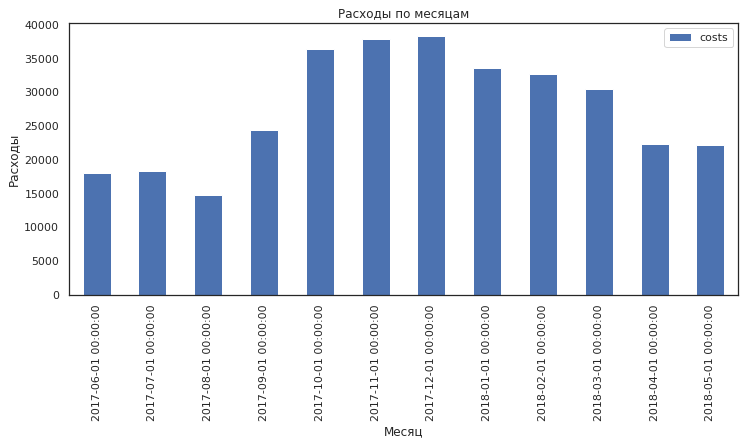

,costs
month,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


In [74]:
#считаем расходы по месяцам

costs.groupby('month').agg({'costs':'sum'}).plot(kind = 'bar', figsize = (12, 5), title = 'Расходы по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.show()

costs.groupby('month').agg({'costs':'sum'})

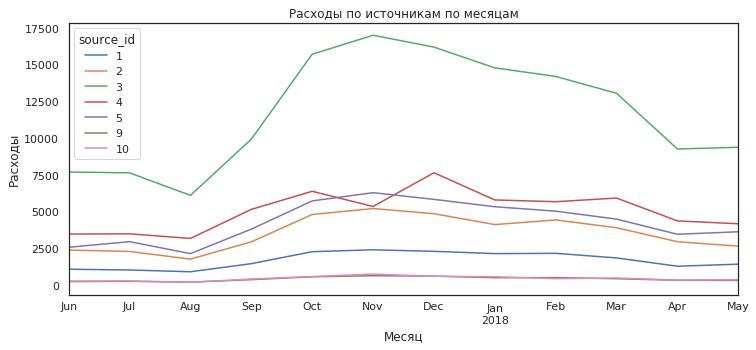

In [75]:
costs.pivot_table(
    index = 'month',
    columns = 'source_id',
    values = 'costs',
    aggfunc = 'sum'
).plot(figsize = (12, 5), title = 'Расходы по источникам по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.show()

### Минивывод:

1. График расходов по месяцам почти совпадает с графиком количества сессий.
2. Больше всего расходов на 3 источник.

In [76]:
print('В среднем в месяц на рекламу тратили: {:.2f}'.format(costs.groupby('month').agg({'costs':'sum'}).mean()[0]))
print('Всего на рекламу потратили:', costs['costs'].sum())

В среднем в месяц на рекламу тратили: 27427.63
Всего на рекламу потратили: 329131.62


### <a id="marketing_2">5.2 Стоимость привлечения одного покупателя</a>

,costs,cohort_size,cac
month,,,
2017-06-01,18015.00,2023,8.905091
2017-07-01,18240.59,1923,9.485486
2017-08-01,14790.54,1370,10.796015
2017-09-01,24368.91,2581,9.441654
2017-10-01,36322.88,4340,8.369327
2017-11-01,37907.88,4081,9.288870
2017-12-01,38315.35,4383,8.741809
2018-01-01,33518.52,3373,9.937302
2018-02-01,32723.03,3651,8.962758


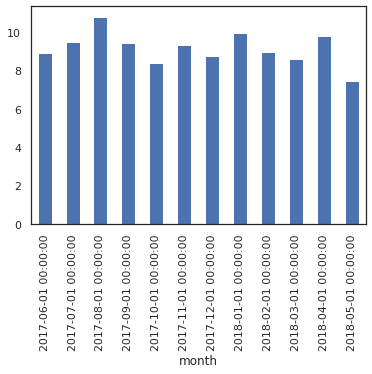

In [78]:
#стоимость привлечения одного покупателя по месяцам

cac_by_month = costs.groupby('month').agg({'costs': 'sum'}).join(cohort_size_by_month)
cac_by_month['cac'] = cac_by_month['costs'] / cac_by_month['cohort_size']
cac_by_month['cac'].plot(kind = 'bar')
cac_by_month

,costs,cohort_size,cac
source_id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


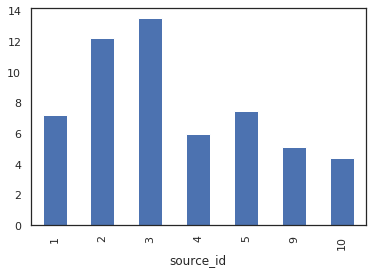

In [79]:
#стоимость привлечения одного покупателя по источникам

cac_by_source = costs.groupby('source_id').agg({'costs': 'sum'}).merge(cohort_size_by_source, on = 'source_id')
cac_by_source['cac'] = cac_by_source['costs'] / cac_by_source['cohort_size']
cac_by_source['cac'].plot(kind = 'bar')
cac_by_source

### Минивывод:

1. Наибольшая стоимость привлечения одного покупателя у источников 3, 2, 1.
2. Наибольшая стоимость привлечения у когорт в августе и апреле.

### <a id="marketing_3">5.3 Окупаемость расходов (ROI)</a>

In [80]:
#объединяем таблицы с ltv и cac и считаем roi по месяцу первой покупки

roi_by_month = ltv_month_sum.join(cac_by_month[['cac']])
roi_by_month = roi_by_month.div(roi_by_month['cac'], axis = 0).drop(columns = 'cac')
roi_by_month.fillna('')

,0,1,2,3,4,5,6,7,8,9,10,11,12
first_buy_date,,,,,,,,,,,,,
2017-06-01,0.534004,0.577518,0.620324,0.716738,0.839621,0.919967,1.02054,1.08234,1.1634,1.23429,1.29904,1.32362,1.33398
2017-07-01,0.63552,0.669602,0.732182,0.770363,0.789778,0.802536,0.816031,0.832604,0.851523,0.866293,0.877764,0.884178,
2017-08-01,0.493146,0.542779,0.582409,0.630577,0.661215,0.687284,0.716114,0.7433,0.770981,0.784708,,,
2017-09-01,0.609424,0.712881,0.816735,1.19019,1.25445,1.33148,1.36604,1.40184,1.41738,1.42297,,,
2017-10-01,0.604301,0.659621,0.686511,0.70387,0.723892,0.735497,0.744891,0.757965,0.759947,,,,
2017-11-01,0.563627,0.597996,0.626627,0.653769,0.670223,0.676952,0.685594,0.688485,,,,,
2017-12-01,0.540152,0.570245,0.675698,0.799101,0.834278,0.872481,0.873951,,,,,,
2018-01-01,0.417652,0.449185,0.480779,0.491387,0.496607,0.497132,,,,,,,
2018-02-01,0.463312,0.495752,0.504066,0.511217,0.511887,,,,,,,,


In [81]:
#объединяем таблицы с ltv и cac и считаем roi по источнику

roi_by_source = ltv_source_sum.merge(cac_by_source[['cac']], on = 'source_id')
roi_by_source = roi_by_source.div(roi_by_source['cac'], axis = 0).drop(columns = 'cac')
roi_by_source.fillna('')

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.856648,0.995056,1.098073,1.188049,1.256449,1.287311,1.325542,1.372997,1.418138,1.454263,1.46911,1.48524,1.49235
2,0.554541,0.659718,0.795940,0.921722,0.974672,1.022526,1.041939,1.060528,1.078791,1.083886,1.09318,1.09591,1.09619
3,0.331831,0.350476,0.360589,0.371142,0.376696,0.379623,0.381432,0.383408,0.384793,0.385172,0.385559,0.385643,0.385725
4,0.772915,0.798770,0.818014,0.834255,0.854442,0.881112,0.900634,0.908838,0.912094,0.918484,0.927652,0.928116,0.928336
5,0.657502,0.684862,0.732506,0.915536,0.947140,0.970386,0.986304,0.998329,1.006381,1.014569,1.01544,1.01672,1.01675
9,0.765279,0.821772,0.869223,0.922635,0.944188,0.973254,0.997615,1.010922,1.034155,1.042150,1.04384,,
10,0.722222,0.736671,0.742894,0.753818,0.757018,0.757621,0.760704,0.763129,0.763757,0.764335,,,


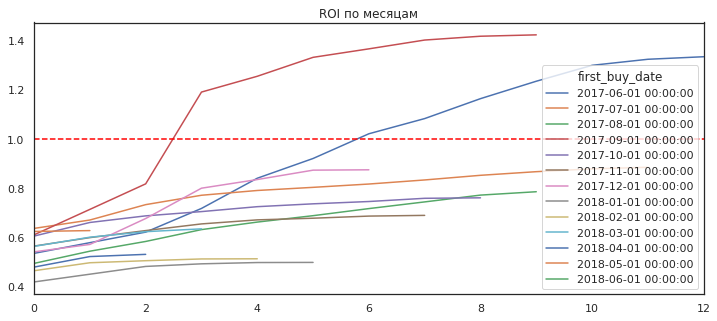

In [82]:
roi_by_month.T.plot(figsize = (12, 5), title = 'ROI по месяцам')
plt.axhline(y=1, linestyle = '--', color = 'red')
plt.show()

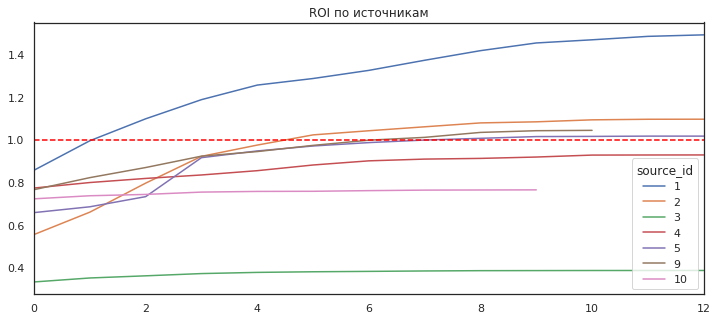

In [83]:
roi_by_source.T.plot(figsize = (12, 5), title = 'ROI по источникам')
plt.axhline(y=1, linestyle = '--', color = 'red')
plt.show()

### Минивывод:

1. Окупились затраты на привлечение только 2 когорт - первой (июньской) и сентябрьской.
2. Окупились затраты по источникам 1, 2, 5, 9.

## <a id="conclusion">6. Выводы</a>

1. 70% пользователей сидят с компьютеров, 30% - с телефонов.
2. Больше всего пользователей из источников под номерами: 4, 3, 5 соответственно.
3. В ноябре был резкий скачок количества уникальных пользователей с компьютеров и пользователей из источников 3 и 4.
4. Количество сессий начало расти в сентябре, и стало снижаться только в марте, что говорит о зависимости от сезона. В холодное время года люди больше заинтересованы в досуге внутри помещений.
5. Количество сессий в день на пользователя достигло максимального значения в ноябре, как и среднее количество сессий в день. Возможно в это время люди планировали, как провести новогодние выходные.
6. Максимальный средний чек в декабре. Резкий скачок среднего чека в декабре у пользователей из 5 источника. У пользователей из 2 источника максимальный средний чек в феврале-марте. Возможно, проводились какие-то акции в честь 23 февраля и 8 марта. Средний чек больше у источников 1, 2, 5.
7. У пользователей с компьютеров максимальный средний чек в декабре, а у пользователей с телефонами в ноябре. Возможно, среди пользователей с телефонами больше молодежи, что объясняет меньший средний чек и пик в ноябре (обычно билеты, купленные заранее, стоят дешевле).
8. Средняя длительность сессии составляет 643 с (10 минут 43 с), медианная - 300с (5 минут), а мода - 60 с.Среднее время от первого посещения до покупки составляет 17+ дней, медианное - 22 минуты, а мода - 0. Возможно, это связано с переходом в личный кабинет или его созданием, если в этот момент меняется uid.
9. Количество покупок растет с сентября по декабрь, затем небольшое падение в январе, и в феврале-марте остается еще довольно высоким. Количество покупок на каждого человека достигает максимума в марте.
10. График расходов по месяцам почти совпадает с графиком количества сессий.
11. Больше всего расходов на 3 источник. Наибольшая стоимость привлечения одного покупателя у источников 3, 2, 1. Наибольшая стоимость привлечения у когорт в августе и апреле.
12. Окупились затраты на привлечение только 2 когорт - первой (июньской) и сентябрьской. Окупились затраты по источникам 1, 2, 5, 9.

Рекомендации:

1. Сокращение расходов на источник 3, так как на него приходятся наибольшие затраты, которые не окупаются (нерентабельно)
2. Увеличить расходы на источник 5 - большой средний чек, затраты окупились.
3. Заинтересовать пользователей из источника 4 (скидки, акции, бонусы и т.д), так как он имеет наибольшее количество пользователей.